<a href="https://colab.research.google.com/github/RufusRubin/KNUCKLE_CLASSIFICATION/blob/main/CONCAT_RESNET_50_INCEPTION_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

! pip install torchview
! pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7da4077cb8193374356930a4aca66ab7879ff26c0e2908a118a6e813f3674895
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=b615bccbd1ca5d0f75f5f8d13e78d3974f1fbbabe5d20d0e8c47655afb6add06
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import models

from torchview import draw_graph
import graphviz


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
root='/kaggle/input/knuckle-dataset/knuckle_datset-20220916T075635Z-001/knuckle_dataset'

In [ ]:
classes=('001', '002', '003', '004', '005', '006', '007', '008', '009','010', '011', '012', '013', '014', '015', '016', '017', '018','019', '020', '021', '022', '023', '024', '025', '026', '027','028', '029', '030', '031', '032', '033', '034', '035', '036','037', '038', '039', '040', '041', '042', '043', '044', '045','046', '047', '048', '049', '050', '051', '052', '053', '054','055', '056', '057', '058', '059', '060', '061', '062', '063','064', '065', '066', '067', '068', '069', '070', '071', '072','073', '074', '075', '076', '077', '078', '079', '080', '081','082', '083', '084', '085', '086', '087', '088', '089', '090','091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117','118', '119', '120', '121', '122', '123', '124', '125', '126','127', '128', '129', '130', '131', '132', '133', '134', '135','136', '137', '138', '139', '140', '141', '142', '143', '144','145', '146', '147', '148', '149', '150', '151', '152', '153','154', '155', '156', '157', '158')


In [ ]:
image_paths = list(paths.list_images('/kaggle/input/knuckle-dataset/knuckle_datset-20220916T075635Z-001/knuckle_dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
labels

array(['135', '135', '135', '135', '135', '057', '057', '057', '057',
       '057', '086', '086', '086', '086', '086', '121', '121', '121',
       '121', '121', '061', '061', '061', '061', '061', '048', '048',
       '048', '048', '048', '053', '053', '053', '053', '053', '147',
       '147', '147', '147', '147', '145', '145', '145', '145', '145',
       '051', '051', '051', '051', '051', '137', '137', '137', '137',
       '137', '095', '095', '095', '095', '095', '018', '018', '018',
       '018', '018', '044', '044', '044', '044', '044', '016', '016',
       '016', '016', '016', '007', '007', '007', '007', '007', '009',
       '009', '009', '009', '009', '012', '012', '012', '012', '012',
       '029', '029', '029', '029', '029', '025', '025', '025', '025',
       '025', '078', '078', '078', '078', '078', '001', '001', '001',
       '001', '001', '056', '056', '056', '056', '056', '006', '006',
       '006', '006', '006', '120', '120', '120', '120', '120', '109',
       '109', '109',

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 158


In [ ]:
#orginal dataset

train_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

test_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])    


#for data augmentation

train_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
# divide the data into train, validation, and test set
#(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
#(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
#print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3,stratify=labels, random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

x_train examples: (553, 100, 80, 3)
x_test examples: (237, 100, 80, 3)


In [ ]:
batch_size=6

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels

        
        
        
        
train_orginal_data = CustomDataset(x_train, y_train, train_orginal_transforms)
test_orginal_data = CustomDataset(x_test, y_test, test_orginal_transforms)     


train_augmentation_data = CustomDataset(x_train, y_train, train_augmentation_transforms )
test_augmentation_data = CustomDataset(x_test, y_test, test_augmentation_transforms )  

train_data = torch.utils.data.ConcatDataset([train_orginal_data,train_augmentation_data])
print(len(train_data))
test_data = torch.utils.data.ConcatDataset([test_orginal_data,test_augmentation_data])
print(len(test_data))




trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory= True)
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory= True) 


1106
474


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for X, y in trainLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([6, 3, 299, 299])
Shape of y: torch.Size([6]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **MODEL**

In [ ]:
original_model_1 = models.resnet50(pretrained=True)
original_model_1

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# the resnet34 model
class ResNet50(nn.Module):
    def __init__(self, pretrained):
        super(ResNet50, self).__init__()

        
        
        self.model = nn.Sequential(*list(original_model_1.children())[:-2])        
        
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)

        x = self.model(x)

        return x

model_1= ResNet50(pretrained=True).to(device)
print(model_1)

ResNet50(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [ ]:
original_model_2 = models.inception_v3(pretrained=True,aux_logits=False)
original_model_2

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# the resnet34 model
class inceptionv3(nn.Module):
    def __init__(self, pretrained):
        super(inceptionv3, self).__init__()

        self.model = nn.Sequential(*list(original_model_2.children())[:-3]) 

        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)

        x = self.model(x)

        return x

model_2= inceptionv3(pretrained=True).to(device)
print(model_2)

inceptionv3(
  (model): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self, model_1, model_2):
        super(MyEnsemble, self).__init__()
        
        self.modelA = model_1
        self.modelB = model_2
        
        self.conv= nn.Conv2d(2048, 2048, kernel_size=(3,3) , stride=1, padding=0)
        
        # change the classification layer
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flatten = nn.Flatten()
        #self.dropout = nn.Dropout2d(0.3)
        self.l0= nn.Linear(4096, len(lb.classes_))
        
    def forward(self, x):

        x1 = self.modelA(x)
        x1= self.conv(x1)


        x2 = self.modelB(x)


        x= torch.cat([x1,x2],dim=1)

        
        x = self.avgpool(x)
        x = self.flatten(x)
        #x = self.dropout(x)
        l0 = self.l0(x)
        return l0

In [ ]:
model= MyEnsemble(model_1, model_2).to(device)
print(model)

MyEnsemble(
  (modelA): ResNet50(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
         

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyEnsemble(model_1, model_2).to(device)

#model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location= device))

model.to(device)
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]           4,096
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]          16,384
      BatchNorm2d-12          [-1, 256, 75, 75]             512
           Conv2d-13          [-1, 256, 75, 75]          16,384
      BatchNorm2d-14          [-1, 256,

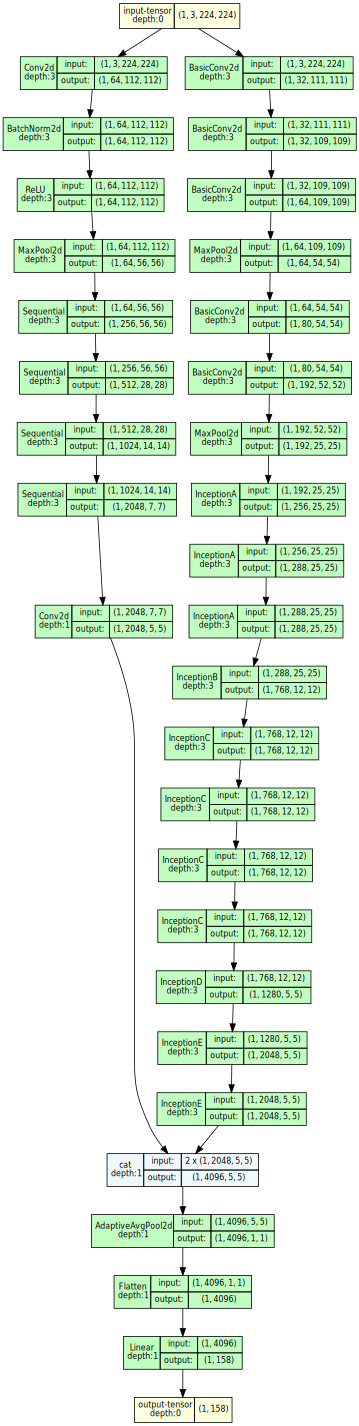

In [ ]:
model_plot = draw_graph(model, input_size=(1,3,224,224))
model_plot.visual_graph

# **OPTIMZER**

In [ ]:
lr = 0.001

WEIGHT_DECAY = 0.0005
save_path = "model.pth"
fine_tune = True
#load_path = "/kaggle/working/model_1.pth"

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

params = list(model_1.parameters()) + list(model_2.parameters()) #+ list(model.parameters())
optimizer= torch.optim.SGD(params, lr= lr, momentum=0.9)

# **LOAD MODEL**

In [ ]:
#state_dict = torch.load(load_path, map_location=device)
#model.load_state_dict(state_dict)

# **TRAINING**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    total=0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")


    return loss, accuracy

# **VALIDATION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total=0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
        
        loss = running_loss/len(dataloader)
        accuracy = 100.*running_correct/total
        #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        print('Test Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


        return loss, accuracy

# **TRAINING AND VALIDATION IN SINGLE FUNCTION**

In [ ]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)



Training on 1106 examples, validating on 474 examples...
Epoch 1 of 50
Training


  0%|          | 0/185 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 185/185 [00:53<00:00,  3.43it/s]

Train Loss: 5.066 | Accuracy: 0.904
Validating


Test Loss: 5.081 | Accuracy: 0.633
Epoch 2 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 5.031 | Accuracy: 1.537
Validating


Test Loss: 5.053 | Accuracy: 1.266
Epoch 3 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 4.980 | Accuracy: 2.080
Validating


Test Loss: 5.023 | Accuracy: 1.055
Epoch 4 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 4.921 | Accuracy: 4.340
Validating


Test Loss: 4.990 | Accuracy: 2.321
Epoch 5 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 4.820 | Accuracy: 7.324
Validating


Test Loss: 4.848 | Accuracy: 5.907
Epoch 6 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.73it/s]

Train Loss: 4.704 | Accuracy: 11.664
Validating


Test Loss: 4.799 | Accuracy: 6.118
Epoch 7 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 4.567 | Accuracy: 16.365
Validating


Test Loss: 4.625 | Accuracy: 8.439
Epoch 8 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 4.442 | Accuracy: 21.248
Validating


Test Loss: 4.627 | Accuracy: 6.962
Epoch 9 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 4.282 | Accuracy: 27.939
Validating


Test Loss: 4.267 | Accuracy: 22.363
Epoch 10 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 4.127 | Accuracy: 35.443
Validating


Test Loss: 4.007 | Accuracy: 27.637
Epoch 11 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 3.978 | Accuracy: 41.230
Validating


Test Loss: 3.823 | Accuracy: 36.920
Epoch 12 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 3.824 | Accuracy: 47.197
Validating


Test Loss: 4.054 | Accuracy: 25.949
Epoch 13 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 3.661 | Accuracy: 55.425
Validating


Test Loss: 3.609 | Accuracy: 40.717
Epoch 14 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 3.516 | Accuracy: 61.754
Validating


Test Loss: 3.600 | Accuracy: 37.131
Epoch 15 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 3.349 | Accuracy: 68.264
Validating


Test Loss: 3.813 | Accuracy: 20.675
Epoch 16 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 3.195 | Accuracy: 73.237
Validating


Test Loss: 3.283 | Accuracy: 47.468
Epoch 17 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.73it/s]

Train Loss: 3.056 | Accuracy: 77.034
Validating


Test Loss: 3.329 | Accuracy: 39.451
Epoch 18 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 2.912 | Accuracy: 80.922
Validating


Test Loss: 3.074 | Accuracy: 50.422
Epoch 19 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 2.738 | Accuracy: 85.262
Validating


Test Loss: 2.294 | Accuracy: 79.536
Epoch 20 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 2.623 | Accuracy: 86.166
Validating


Test Loss: 2.880 | Accuracy: 50.000
Epoch 21 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 2.456 | Accuracy: 89.964
Validating


Test Loss: 2.073 | Accuracy: 80.591
Epoch 22 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 2.373 | Accuracy: 89.602
Validating


Test Loss: 2.144 | Accuracy: 81.224
Epoch 23 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 2.175 | Accuracy: 91.863
Validating


Test Loss: 2.122 | Accuracy: 77.848
Epoch 24 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]


Train Loss: 2.043 | Accuracy: 94.665
Validating
Test Loss: 1.845 | Accuracy: 84.177
Epoch 25 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 1.923 | Accuracy: 95.118
Validating


Test Loss: 2.100 | Accuracy: 75.105
Epoch 26 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 1.788 | Accuracy: 96.203
Validating


Test Loss: 1.665 | Accuracy: 86.287
Epoch 27 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 1.684 | Accuracy: 96.835
Validating


Test Loss: 1.140 | Accuracy: 94.515
Epoch 28 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.73it/s]

Train Loss: 1.530 | Accuracy: 97.920
Validating


Test Loss: 1.408 | Accuracy: 88.819
Epoch 29 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 1.453 | Accuracy: 98.915
Validating


Test Loss: 1.226 | Accuracy: 91.983
Epoch 30 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.72it/s]

Train Loss: 1.338 | Accuracy: 98.825
Validating


Test Loss: 0.983 | Accuracy: 94.304
Epoch 31 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 1.267 | Accuracy: 98.915
Validating


Test Loss: 1.116 | Accuracy: 91.772
Epoch 32 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 1.156 | Accuracy: 99.096
Validating


Test Loss: 1.260 | Accuracy: 88.186
Epoch 33 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 1.058 | Accuracy: 99.367
Validating


Test Loss: 0.628 | Accuracy: 96.414
Epoch 34 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 0.971 | Accuracy: 99.729
Validating


Test Loss: 0.967 | Accuracy: 93.249
Epoch 35 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.911 | Accuracy: 99.638
Validating


Test Loss: 0.571 | Accuracy: 95.570
Epoch 36 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.846 | Accuracy: 99.910
Validating


Test Loss: 0.517 | Accuracy: 95.781
Epoch 37 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 0.777 | Accuracy: 99.910
Validating


Test Loss: 0.512 | Accuracy: 95.359
Epoch 38 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 0.747 | Accuracy: 99.638
Validating


Test Loss: 0.839 | Accuracy: 92.616
Epoch 39 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.72it/s]

Train Loss: 0.675 | Accuracy: 99.910
Validating


Test Loss: 0.425 | Accuracy: 96.414
Epoch 40 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.623 | Accuracy: 99.729
Validating


Test Loss: 0.404 | Accuracy: 95.781
Epoch 41 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.550 | Accuracy: 99.910
Validating


Test Loss: 0.620 | Accuracy: 95.992
Epoch 42 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.549 | Accuracy: 100.000
Validating


Test Loss: 0.309 | Accuracy: 97.046
Epoch 43 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 0.494 | Accuracy: 100.000
Validating


Test Loss: 0.429 | Accuracy: 96.414
Epoch 44 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.74it/s]

Train Loss: 0.460 | Accuracy: 99.910
Validating


Test Loss: 0.369 | Accuracy: 96.835
Epoch 45 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.452 | Accuracy: 100.000
Validating


Test Loss: 0.543 | Accuracy: 94.937
Epoch 46 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.418 | Accuracy: 99.910
Validating


Test Loss: 0.282 | Accuracy: 96.624
Epoch 47 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.395 | Accuracy: 99.910
Validating


Test Loss: 0.389 | Accuracy: 96.203
Epoch 48 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.380 | Accuracy: 100.000
Validating


Test Loss: 0.545 | Accuracy: 94.937
Epoch 49 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.76it/s]

Train Loss: 0.339 | Accuracy: 99.910
Validating


Test Loss: 0.254 | Accuracy: 96.835
Epoch 50 of 50
Training


100%|██████████| 185/185 [00:49<00:00,  3.75it/s]

Train Loss: 0.335 | Accuracy: 100.000
Validating


Test Loss: 0.290 | Accuracy: 96.835


# **MODEL SAVING**

In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = MyEnsemble(model_1, model_2).to(device)
#model.load_state_dict(torch.load("model.pth"))

state_dict = torch.load(f"/kaggle/working/{save_path}")
model.load_state_dict(state_dict)


<All keys matched successfully>

# **VISUALIZE PREDICTING IMAGE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testLoader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    images=images.to(device)
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

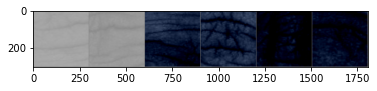

Real labels:    038   095   155   004   101   073
Predicted:    038   095   155   004   150   073


In [ ]:
testBatch()

# **PLOT ACCURACY**

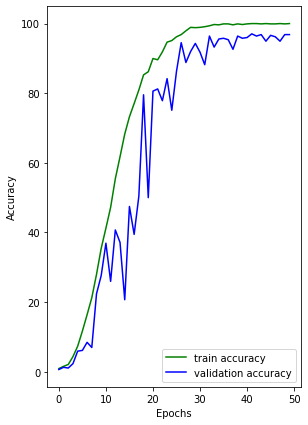

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')

# **PLOT LOSS**

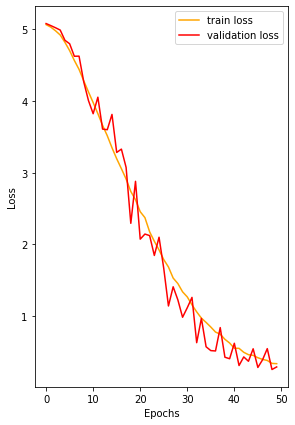

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [ ]:
label2class ={ 1 :'001', 2 :'002', 3:'003', 4:'004', 5:'005', 6:'006', 7:'007', 8:'008', 9:'009', 10:'010', 11:'011', 12:'012', 13:'013', 14:'014', 15:'015', 16:'016', 17:'017', 18:'018', 19:'019', 20:'020', 21:'021', 22:'022', 23:'023', 24:'024', 25:'025', 26:'026', 27:'027', 28:'028', 29:'029', 30:'030', 31:'031', 32:'032', 33:'033', 34:'034', 35:'035', 36:'036', 37:'037', 38:'038', 39:'039', 40:'040', 41:'041', 42:'042', 43:'043', 44:'044', 45:'045',46:'046', 47:'047', 48:'048', 49:'049', 50:'050', 51:'051', 52:'052', 53:'053', 54:'054',55:'055', 56:'056', 57:'057', 58:'058', 59:'059', 60:'060', 61:'061', 62:'062', 63:'063',64:'064', 65:'065', 66:'066', 67:'067', 68:'068', 69:'069', 70:'070', 71:'071', 72:'072',73:'073', 74:'074', 75:'075', 76:'076', 77:'077', 78:'078', 79:'079', 80:'080', 81:'081', 82:'082', 83:'083', 84:'084', 85:'085', 86:'086', 87:'087', 88:'088', 89:'089', 90:'090',91:'091', 92:'092', 93:'093', 94:'094', 95:'095', 96:'096', 97:'097', 98:'098', 99:'099', 100:'100', 101:'101', 102:'102', 103:'103', 104:'104', 105:'105', 106:'106', 107:'107', 108:'108', 109:'109', 110:'110', 111:'111', 112:'112', 113:'113', 114:'114', 115:'115', 116:'116', 117:'117',118:'118', 119:'119', 120:'120', 121:'121', 122:'122', 123:'123', 124:'124', 125:'125', 126:'126',127:'127', 128:'128', 129:'129', 130:'130', 131:'131', 132:'132', 133:'133', 134:'134', 135:'135',136:'136', 137:'137', 138:'138', 139:'139', 140:'140', 141:'141', 142:'142', 143:'143', 144:'144',145:'145', 146:'146', 147:'147', 148:'148', 149:'149', 150:'150', 151:'151', 152:'152', 153:'153',154:'154', 155:'155', 156:'156', 157:'157', 158:'158'}


In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch,(inputs, labels) in enumerate(testLoader):
    
    
        inputs= inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        

report = classification_report(y_true, y_pred)
print(report)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       0.80      1.00      0.89         4
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         4
          15       0.50      1.00      0.67         2
          16       1.00      1.00      1.00         2
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Text(0.5, 879.0, 'Predicted label')

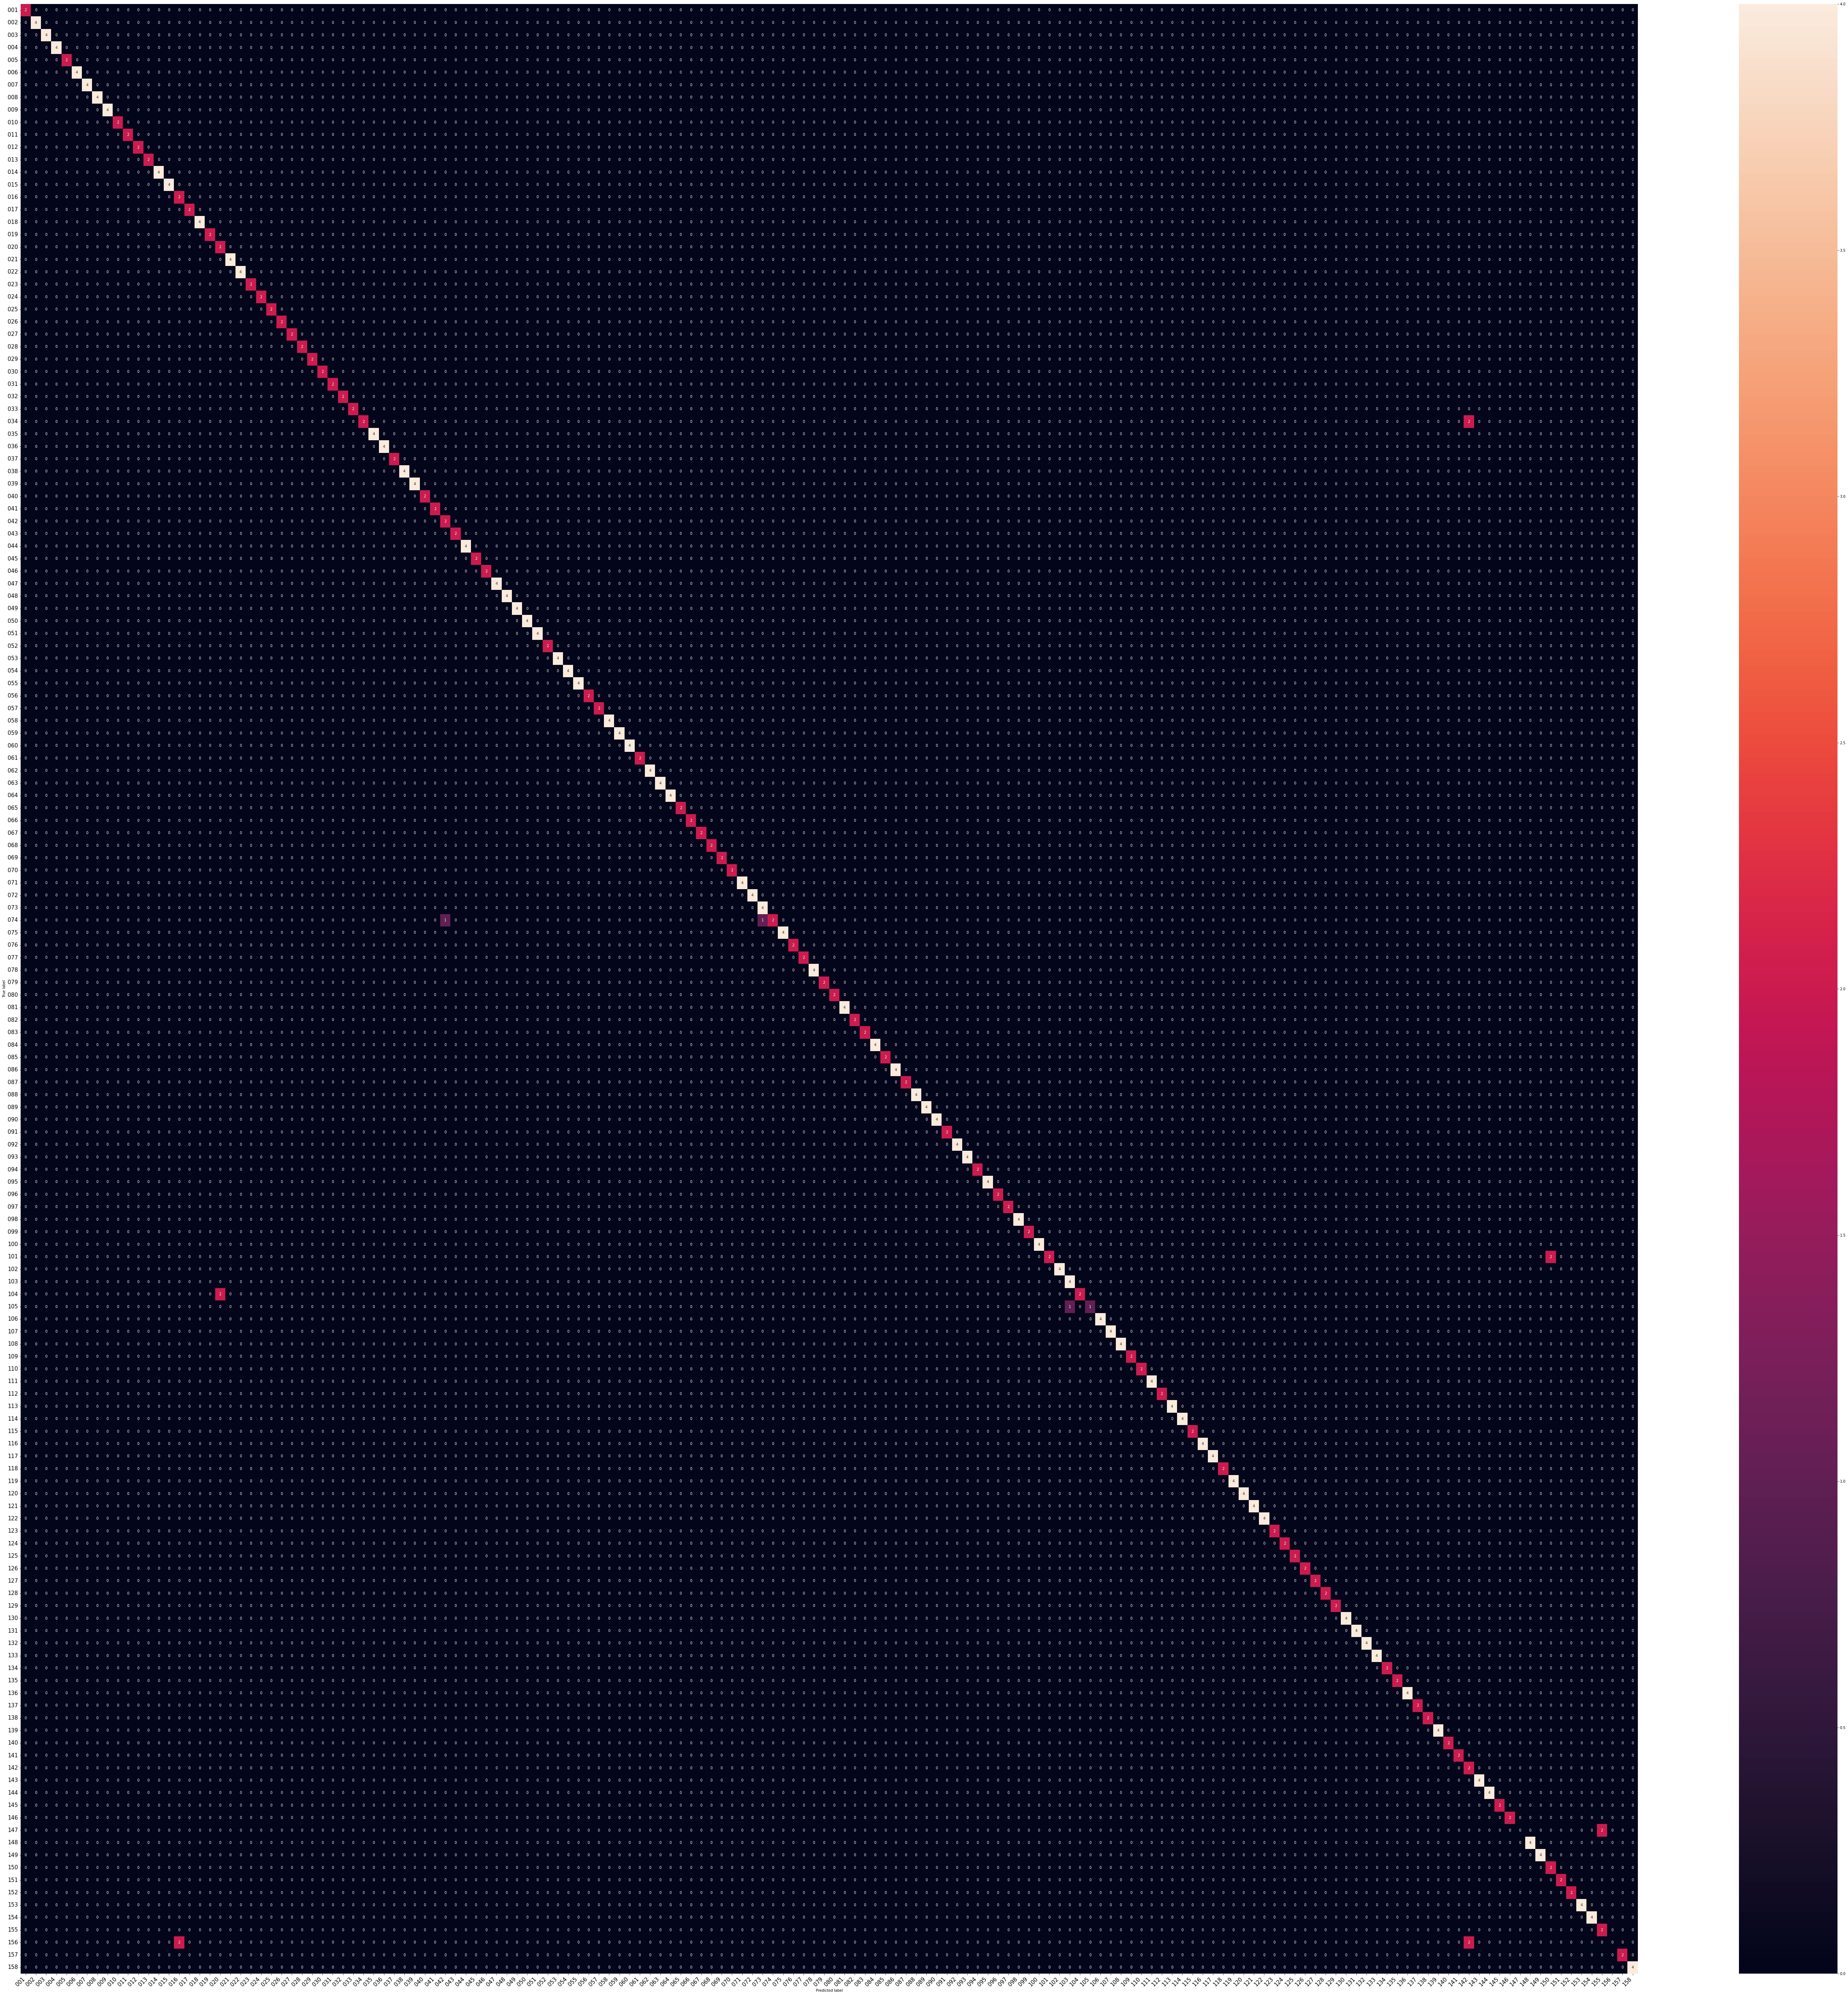

In [ ]:
nb_classes = 158
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(100,100))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')